In [1]:
%run pretrained-model.ipynb

CUDA Available:  True
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)


In [2]:
import torch
import numpy as np
import random
from torchvision import datasets, transforms
from torch.autograd.functional import jacobian

In [3]:
def jsma_jacobian(model, X):
    f = lambda image: model(image).to(device)
    
    # output shape 10 x 784
    return jacobian(f, X).squeeze().reshape(-1,28*28)

In [4]:
def saliency_map(jacobian, target, increasing, search_space, probability, image):
    """Compute saliency map of an image

    jacobian:     The jacobian matrix
    target:       The target label
    increasing:   Denote the use of incrementing or decrementing pixels method
    search_space: The image search space 
    probability:  The probability predicted by the model of all classes
    image:        The input image X
    
    return:       The saliency map
    """ 
    # add the Taylor term to all classes but the target class
    probability[0, target] = 1
    taylor = 1 - image if increasing else image
    jacobian *= probability.reshape(10,1) * taylor 
    
    # The forward derivative of the target class
    target_grad = jacobian[target]  
    # The sum of forward derivative of all other classes
    others_grad = torch.sum(jacobian, dim=0) - target_grad  
    
    # Crossout pixels not in the search space
    target_grad *= search_space 
    others_grad *= search_space

    # Calculate sum of target forward derivative of any 2 features.
    alpha = target_grad.reshape(-1, 1, 784) + target_grad.reshape(-1, 784, 1)  
    # Calculate sum of other forward derivative of any 2 features.
    beta = others_grad.reshape(-1, 1, 784) + others_grad.reshape(-1, 784, 1)

    # Cross out entries that does not satisfy the condition (from formula 8 and 9)
    condition1 = alpha < 0.0 if increasing else alpha > 0.0
    condition2 = beta > 0.0 if increasing else beta < 0.0
    zero_mask = torch.ones(784, 784).fill_diagonal_(0).to(device)

    # Apply the condition to the saliency map
    mask = (condition1 * condition2) * zero_mask
    
    # Form the actuall map, entries are either invalid (crossed out) or equal alpha x beta
    saliency_map = torch.abs(alpha) * beta if increasing else alpha * torch.abs(beta)
    saliency_map *= mask # cross out invalid entries
    
    # get the two most significant pixels
    _, idx = torch.max(saliency_map.reshape(-1, 784 * 784), dim=1)
    
    p1 = torch.div(idx, 784, rounding_mode='floor')
    p2 = idx % 784
    
    return p1.item(), p2.item()

In [5]:
def jsma(image, label, step_size, max_iters, model):
    """Perform JSMA attack on an image

    image:     The input image X
    label:     The image label
    step_size: The perturbation size
    max_iters: The maximum itrations of the attack
    model:     The prediction model
    
    return:    The adversatial image X*
    """ 
        
    shape = image.shape
    image = torch.flatten(image) # Flatten the image to 1D for easier modification 
    
    increasing    = True if step_size > 0 else False
    search_domain = image < 1 if increasing else image > 0
    
    # Label predicted by the model
    probability = model(image.reshape(shape))
    prediction = torch.argmax(probability).item()

    iter_ = 0
    while (iter_ < max_iters) and (prediction == label) and (search_domain.sum() != 0):
        # Calculate Jacobian matrix 
        jacobian = jsma_jacobian(model, image.reshape(shape))
        # Get the two most salient pixels
        p1, p2 = saliency_map(jacobian, label, increasing, search_domain, probability, image)
        
        # Modify pixels, and clip the image
        image[p1] += step_size
        image[p2] += step_size
        image = torch.clamp(image, min=0.0, max=1.0)
        
        # Cross out modified pixels in the search space
        search_domain[p1] = 0
        search_domain[p2] = 0
        
        # Update the new label predicted by the model
        probability = model(image.reshape(shape))
        prediction = torch.argmax(probability).item()

        iter_ += 1

    return image.reshape(shape)

cuda


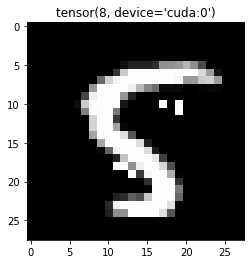

In [6]:
test_loader_iter = iter(test_loader)
input1 = next(test_loader_iter)
print(device)
adv_image = jsma(image     = input1[0].to(device), 
                 label     = input1[1].item(),  
                 step_size = 1, 
                 max_iters = 40,
                 model     = model).reshape([1,1,28,28])

import matplotlib.pyplot as plt

plt.title(torch.argmax(model(adv_image)))
plt.imshow(adv_image.squeeze().cpu(), cmap="gray")

In [7]:
correct = 0

for j in range(1000):
    image, label = next(test_loader_iter)
    
    initial_prediction = torch.argmax(model(image.to(device))).item()
    # Don't bother attacking if the image is already misclassified
    if initial_prediction != label:
        continue

    adv_image = jsma(image     = image.to(device), 
                     label     = label,  
                     step_size = 1, 
                     max_iters = 40,
                     model     = model).reshape([1,1,28,28])

    prediction = torch.argmax(model(adv_image)).item()

    # Correct if the prediction is the target label
    if prediction != label:
        correct += 1
    
    print(correct, '/', j+1, correct * 100 / (j+1))

1 / 1 100.0
2 / 2 100.0
3 / 3 100.0
4 / 4 100.0
5 / 5 100.0
6 / 6 100.0
7 / 7 100.0
8 / 8 100.0
9 / 9 100.0
10 / 10 100.0
11 / 11 100.0
12 / 12 100.0
13 / 13 100.0
14 / 14 100.0
15 / 15 100.0
16 / 16 100.0
17 / 17 100.0
18 / 18 100.0
19 / 19 100.0
20 / 20 100.0
21 / 22 95.45454545454545
22 / 23 95.65217391304348
23 / 24 95.83333333333333
24 / 25 96.0
25 / 26 96.15384615384616
26 / 27 96.29629629629629
27 / 28 96.42857142857143
28 / 29 96.55172413793103
29 / 30 96.66666666666667
30 / 31 96.7741935483871
31 / 32 96.875
32 / 33 96.96969696969697
33 / 34 97.05882352941177
34 / 35 97.14285714285714
35 / 36 97.22222222222223
36 / 37 97.29729729729729
37 / 38 97.36842105263158
38 / 39 97.43589743589743
39 / 40 97.5
40 / 41 97.5609756097561
41 / 42 97.61904761904762
42 / 43 97.67441860465117
43 / 44 97.72727272727273
44 / 45 97.77777777777777
45 / 46 97.82608695652173
46 / 47 97.87234042553192
47 / 48 97.91666666666667
48 / 49 97.95918367346938
49 / 50 98.0
50 / 51 98.03921568627452
51 / 52 98

KeyboardInterrupt: 